## To Do

- Should we remove patients with a missing Date of Birth? 
- Additional manual, spot-checking of ICD & CPT code category cuts. 
- Re-run RxNav API calls by using "drug_strength" if "StrengthText" missing or if "drug_strength" contains a "mg"
    - Consider whether we want to expand on "mg" to things like "mcg" etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import config
import api_rxnorm
import DatasetCreation

# Load Data

In [3]:
dir = '../data/'
prefix = 'FONNESBECK_'
suffix = '_20151202.csv'

In [4]:
adt = pd.read_csv(dir + prefix + 'ADT' + suffix, encoding='latin1')
adt.columns = adt.columns.str.lower()
adt.head()

,ruid,event,admission_date,event_date,srv_code,chief_complaint,discharge_date
0,50135262,Admit,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
1,50135262,Transfer,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
2,50135262,Transfer,02/08/2007,02/09/2007,ORT,R FEMUR FX,02/12/2007
3,50135262,Discharge,02/08/2007,02/12/2007,ORT,R FEMUR FX,02/12/2007
4,50135262,Transfer,02/11/2011,02/11/2011,NEU,SEIZURES;HYPERGLYCEMIA,02/23/2011


In [5]:
adt_cms_final = pd.read_pickle(dir + './adt_cms_final.pkl')
adt_cms_final.head()

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,NaT,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,NaT,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,NaT,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,NaT,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,NaT,0


In [ ]:
cpt = pd.read_csv(dir + prefix + 'CPT' + suffix)
cpt.columns = cpt.columns.str.lower()
cpt.head()

In [ ]:
icd = pd.read_csv(dir + prefix + 'ICD9' + suffix, parse_dates=['Event_date'])
icd.columns = icd.columns.str.lower()
icd.head()

In [ ]:
# can't get this to work (Alvin)
# I have no trouble opening it in R
#library(data.table)
#df <- fread('/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB_20151202.csv')
#write.csv(df, file = '/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB2_20151202.csv')

#lab = pd.read_csv(dir + prefix + 'LAB' + suffix) # engine='python' produces a different error
#lab.head()

In [6]:
med = pd.read_csv(dir + prefix + 'MED' + suffix) # parse dates took a long time to load
med.columns = med.columns.str.lower()

# sort values to assist with duplicate removal later
med.sort_values(by=['ruid', 'entry_date', 'drug_name', 'dose_amt'], inplace=True)
med.head()

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN


In [ ]:
phenotype = pd.read_csv(dir + prefix + 'phenotype' + suffix, parse_dates=['DOB', 'DOD'])
phenotype.columns = phenotype.columns.str.lower()
phenotype.head()

# Phenotype

In [ ]:
phenotype.describe(include='all')

In [ ]:
uniq = len(np.unique(phenotype.ruid))

print("Shape of phenotype = {shape}. Unique RUIDs = {uniq}.".format(
    shape=phenotype.shape, uniq=uniq))

In [ ]:
females = sum(phenotype.sex=='F')
males = sum(phenotype.sex=='M')
unknown = sum(phenotype.sex=='U')
miss = phenotype.sex.isnull().sum()
assert(females + males + unknown + miss == uniq)

print("Females = {f}, Males = {m}, Unknown = {u}, NA = {na}".format(
  f=females, m=males, u=unknown, na=miss))

In [ ]:
def pie_chart(labels, df, var, title, font=14, figsize=(2, 2)):
    """
    Create pie chart of categorical variables.
    Inpute: labels (as a list), var - column from dataframe, title for figure
    """
    sizes = []
    for lab in labels: 
        sizes.append(len(df[df[var] == lab]))
    fig1, ax1 = plt.subplots()
    font = {'family' : 'monospace',
          'size'   : font}
    plt.rcParams["figure.figsize"] = figsize
    plt.rc('font', **font) 
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance=0.8, startangle=90)
    ax1.axis('equal'); ax1.set_title(title, y=1.08); plt.show()

In [ ]:
pie_chart(['M', 'F', 'U'], phenotype, 'sex', 'Sex')

In [ ]:
asian = sum(phenotype.race=='A')
black = sum(phenotype.race=='B')
hispanic = sum(phenotype.race=='H')
indian = sum(phenotype.race=='I')
other = sum(phenotype.race=='N')
unknown = sum(phenotype.race=='U')
white = sum(phenotype.race=='W')
assert(asian + black + hispanic + indian + other + unknown + white == uniq)

print("Asian = {a}, Black = {b}, Hispanice = {h}, American Indian = {i}, Other = {n}, Unknown = {u}, White = {w}".format( \
  a=asian, b=black, h=hispanic, i=indian, n=other, u=unknown, w=white))

In [ ]:
pie_chart(['A', 'B', 'H', 'I', 'N', 'U', 'W'], phenotype, 'race', 'Race', figsize=(5, 5))

In [ ]:
# missing DOB or sex
potential_removal = phenotype[phenotype.dob.isnull() | phenotype.sex.isnull()]
potential_removal

In [ ]:
potential_removal.shape

# ICD Codes

In [ ]:
icd.tail()

In [ ]:
uniq = len(np.unique(icd.ruid))
codes = set(icd.icd9_code)

print("Shape of ICD = {shape}. Unique RUIDs = {uniq}. Unique ICD9 Codes = {codes}.".format(
    shape=icd.shape, uniq=uniq, codes=len(codes)))

In [ ]:
icd2 = icd.copy()

In [ ]:
# create a new column of numeric version of codes, making strings NaN
icd2['code_num'] = pd.to_numeric(icd2.icd9_code, errors='coerce')
icd2.tail()

In [ ]:
icd2['code_cat'] = pd.cut(icd2.code_num, bins=[0, 1, 140, 240, 280, 290, 320, 
                                              390, 460, 520, 580, 630, 
                                              680, 710, 740, 760, 780, 800, 1000], 
                          right=False, # closed on the left, non-inclusive on the right
                          labels=['proc', 'dx_infection', 'dx_neoplasm', 'dx_endocrine', 'dx_blood', 'dx_mental', 'dx_nervous', 
                                 'dx_circulatory', 'dx_respiratory', 'dx_digestive', 'dx_gu', 'dx_obstetric', 
                                 'dx_skin', 'dx_muscskel', 'dx_congenital', 'dx_perinatal', 'dx_symptoms', 'dx_injury'])

icd2.code_cat = np.where(icd2.icd9_code.str.contains('V'), 'visit', icd2.code_cat)
icd2.code_cat = np.where(icd2.icd9_code.str.contains('E'), 'dx_external', icd2.code_cat)

In [ ]:
icd2.head()

In [ ]:
icd2.tail()

In [ ]:
dx_dict = {}
for dx in set(icd2.code_cat):
    dx_dict[dx] = sum(icd2.code_cat==str(dx))

assert(sum(dx_dict.values()) == icd.shape[0])

In [ ]:
dx_dict

In [ ]:
pie_chart(dx_dict.keys(), icd2, 'code_cat', 'ICD9 Codes', figsize = (10, 10))

In [ ]:
icd2.head()

In [ ]:
# add counts of ICD9 categories for each day/patient combination
icd_wide = icd2.copy()
icd_wide = (icd_wide.drop(columns=['icd9_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

icd_wide.head()

In [ ]:
icd_wide.tail()

In [101]:
icd_wide.to_pickle(dir + 'icd_wide.pkl')

In [102]:
icd_wide = pd.read_pickle(dir + './icd_wide.pkl')
icd_wide.head()

code_cat             dx_blood  dx_circulatory  dx_congenital  dx_digestive  \
ruid     event_date                                                          
50135262 1991-06-25       0.0             0.0            0.0           0.0   
         2002-02-16       0.0             1.0            0.0           0.0   
         2002-11-12       0.0             2.0            0.0           0.0   
         2002-11-17       0.0             0.0            0.0           0.0   
         2002-11-20       0.0             0.0            0.0           0.0   

code_cat             dx_endocrine  dx_external  dx_gu  dx_infection  \
ruid     event_date                                                   
50135262 1991-06-25           2.0          0.0    0.0           0.0   
         2002-02-16           1.0          0.0    0.0           0.0   
         2002-11-12           2.0          0.0    0.0           0.0   
         2002-11-17           3.0          0.0    0.0           0.0   
         2002-11-20           1.0          0.0    0.0           0.0   

code_cat             dx_injury  dx_mental  dx_muscskel  dx_neoplasm  \
ruid     event_date                                                   
50135262 1991-06-25        0.0        1.0          0.0          0.0   
         2002-02-16        0.0        0.0          0.0          0.0   
         2002-11-12        0.0        0.0          0.0          0.0   
         2002-11-17        0.0        0.0          0.0          0.0   
         2002-11-20        0.0        0.0          0.0          0.0   

code_cat             dx_nervous  dx_obstetric  dx_perinatal  dx_respiratory  \
ruid     event_date                                                           
50135262 1991-06-25         0.0           0.0           0.0             0.0   
         2002-02-16         0.0           0.0           0.0             0.0   
         2002-11-12         0.0           0.0           0.0             0.0   
         2002-11-17         0.0           0.0           0.0             0.0   
         2002-11-20         0.0           0.0           0.0             0.0   

code_cat             dx_skin  dx_symptoms  proc  visit  
ruid     event_date                                     
50135262 1991-06-25      0.0          0.0   0.0    0.0  
         2002-02-16      0.0          0.0   0.0    0.0  
         2002-11-12      0.0          0.0   0.0    0.0  
         2002-11-17      0.0          0.0   0.0    0.0  
         2002-11-20      0.0          0.0   0.0    0.0

# CPT Codes

In [5]:
cpt.tail()

,ruid,cpt_code,event_date
3827383,53736423,86850,04/25/2006
3827384,53736423,86880,04/25/2006
3827385,53736423,86900,04/25/2006
3827386,53736423,86901,04/25/2006
3827387,53736423,90744,04/23/2006


In [6]:
uniq = len(np.unique(cpt.ruid))
codes = set(cpt.cpt_code)

print("Shape of CPT = {shape}. Unique RUIDs = {uniq}. Unique CPT Codes = {codes}.".format(
    shape=cpt.shape, uniq=uniq, codes=len(codes)))

Shape of CPT = (3827388, 3). Unique RUIDs = 7891. Unique CPT Codes = 7274.


In [7]:
# are any non-numeric CPT codes present - yes!
np.unique(cpt.cpt_code)

array([' J751', '00001', '00002', ..., 'V5363', 'V5364', 'Y1405'],
      dtype=object)

In [8]:
cpt2 = cpt.copy()

In [9]:
# create a new column of numeric version of codes, making strings NaN
cpt2['code_num'] = pd.to_numeric(cpt2.cpt_code, errors='coerce')
cpt2.tail()

,ruid,cpt_code,event_date,code_num
3827383,53736423,86850,04/25/2006,86850.0
3827384,53736423,86880,04/25/2006,86880.0
3827385,53736423,86900,04/25/2006,86900.0
3827386,53736423,86901,04/25/2006,86901.0
3827387,53736423,90744,04/23/2006,90744.0


In [73]:
cpt2['code_cat'] = pd.cut(cpt2.code_num, bins=[0, 99, # expired codes
                                               100-0.01, 1999, # anethesia
                                               10000-0.01, 69990, # surgery
                                               70000-0.01, 79999, # radiology
                                               80000-0.01, 89398, # pathology & laboratory
                                               90281-0.01, 99099, # medicine
                                               99100-0.01, 99150, # anesthesia
                                               99151-0.01, 99199, # medicine
                                               99201-0.01, 99499, # evaluation & management
                                               99500-0.01, 99607, # medicine
                                               99608-0.01, 100000, # unknown2
                                               ],
                          # by default, it doesn't include value on the left, so -0.01 added
                          right=True, # inclusive on the right
                          # labels must be unique in the pandas cut() function
                          labels=['expired', 'gap0',
                                  'anesthesia1', 'gap1', 
                                  'surgery', 'gap2',
                                  'radiology', 'gap3', 
                                  'path_lab', 'gap4', 
                                  'medicine1', 'gap5',
                                  'anesthesia2', 'gap6',
                                  'medicine2', 'gap7',
                                  'eval_manage', 'gap8',
                                  'medicine3', 'gap9',
                                  'unknown1'
                                 ])

# remove numbers from labels
cpt2.code_cat = cpt2.code_cat.str.replace('\d+', '', regex=True)

# for Category 2 & 3 CPT codes (i.e., those that include a letter rather than all numbers), 
# marks as "modifier" (the CPT terminology), which are optional for billing purposes
cpt2.code_cat = np.where(np.isnan(cpt2.code_num), 'modifier', cpt2.code_cat)

In [74]:
cpt2.head()

,ruid,cpt_code,event_date,code_num,code_cat
0,50135262,00001,11/28/2004,1.0,expired
1,50135262,00005,05/03/2012,5.0,expired
2,50135262,00025,02/08/2007,25.0,expired
3,50135262,00025,11/16/2004,25.0,expired
4,50135262,00030,02/08/2007,30.0,expired


In [75]:
cpt2.tail()

,ruid,cpt_code,event_date,code_num,code_cat
3827383,53736423,86850,04/25/2006,86850.0,path_lab
3827384,53736423,86880,04/25/2006,86880.0,path_lab
3827385,53736423,86900,04/25/2006,86900.0,path_lab
3827386,53736423,86901,04/25/2006,86901.0,path_lab
3827387,53736423,90744,04/23/2006,90744.0,medicine


In [76]:
# what are the 'unknown' values?
np.unique(cpt2[cpt2.code_cat=='unknown']['cpt_code'])

array(['99999'], dtype=object)

I couldn't find 99999 anywhere - perhaps this just means missing & should be removed?

In [77]:
# what are the 'gap' values?
np.unique(cpt2[cpt2.code_cat=='gap']['cpt_code'])

array(['01999.1', '01999.2', '01999.3', '01999.4', '01999.5', '01999.6',
       '01999.7', '01999.8', '89399', '9999'], dtype=object)

I've never seen decimal places in a CPT code, so we could either label these as modifiers or just remove them (similar to 9999, which isn't a correct CPT code as it only has 4 digits).  

In [78]:
# replace "gap" with unknown
cpt2.code_cat = np.where(cpt2.code_cat=='gap', 'unknown', cpt2.code_cat)

In [79]:
code_dict = {}
for code in set(cpt2.code_cat):
    code_dict[code] = sum(cpt2.code_cat==str(code))

assert(sum(code_dict.values()) == cpt2.shape[0])

code_dict

{'radiology': 192170,
 'anesthesia': 6526,
 'path_lab': 1813333,
 'expired': 81986,
 'surgery': 179513,
 'modifier': 625824,
 'unknown': 5964,
 'medicine': 474569,
 'eval_manage': 447503}

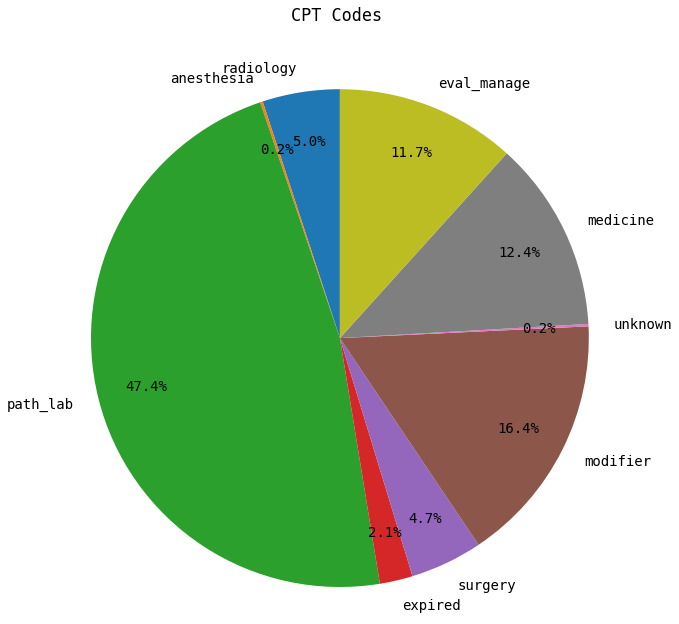

In [80]:
pie_chart(code_dict.keys(), cpt2, 'code_cat', 'CPT Codes', figsize = (10, 10))

In [81]:
cpt2.head()

,ruid,cpt_code,event_date,code_num,code_cat
0,50135262,00001,11/28/2004,1.0,expired
1,50135262,00005,05/03/2012,5.0,expired
2,50135262,00025,02/08/2007,25.0,expired
3,50135262,00025,11/16/2004,25.0,expired
4,50135262,00030,02/08/2007,30.0,expired


In [82]:
# add counts of CPT categories for each day/patient combination
cpt_wide = cpt2.copy()
cpt_wide = (cpt_wide.drop(columns=['cpt_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

cpt_wide.head()

code_cat             anesthesia  eval_manage  expired  medicine  modifier  \
ruid     event_date                                                         
50135262 01/09/2005         0.0          1.0      0.0       1.0       0.0   
         02/08/2007         0.0          1.0      2.0       4.0       2.0   
         02/09/2007         0.0          2.0      1.0       0.0       3.0   
         02/10/2007         0.0          1.0      0.0       7.0       2.0   
         02/11/2007         0.0          1.0      0.0       2.0       1.0   

code_cat             path_lab  radiology  surgery  unknown  
ruid     event_date                                         
50135262 01/09/2005       0.0        0.0      0.0      0.0  
         02/08/2007      10.0        4.0      0.0      0.0  
         02/09/2007       9.0        5.0      2.0      0.0  
         02/10/2007       2.0        0.0      0.0      0.0  
         02/11/2007       2.0        0.0      0.0      0.0

In [83]:
cpt_wide.tail()

code_cat             anesthesia  eval_manage  expired  medicine  modifier  \
ruid     event_date                                                         
53736422 12/06/2006         0.0          1.0      0.0       0.0       0.0   
         12/25/2007         0.0          1.0      0.0       1.0       0.0   
53736423 04/23/2006         0.0          0.0      1.0       1.0       0.0   
         04/24/2006         0.0          0.0      1.0       0.0       0.0   
         04/25/2006         0.0          0.0      1.0       0.0       0.0   

code_cat             path_lab  radiology  surgery  unknown  
ruid     event_date                                         
53736422 12/06/2006       0.0        0.0      0.0      0.0  
         12/25/2007       0.0        0.0      0.0      0.0  
53736423 04/23/2006       1.0        0.0      0.0      0.0  
         04/24/2006       0.0        0.0      1.0      0.0  
         04/25/2006       7.0        0.0      0.0      0.0

In [84]:
cpt_wide.to_pickle(dir + 'cpt_wide.pkl')

In [85]:
cpt_wide = pd.read_pickle(dir + './cpt_wide.pkl')
cpt_wide.head()

code_cat             anesthesia  eval_manage  expired  medicine  modifier  \
ruid     event_date                                                         
50135262 01/09/2005         0.0          1.0      0.0       1.0       0.0   
         02/08/2007         0.0          1.0      2.0       4.0       2.0   
         02/09/2007         0.0          2.0      1.0       0.0       3.0   
         02/10/2007         0.0          1.0      0.0       7.0       2.0   
         02/11/2007         0.0          1.0      0.0       2.0       1.0   

code_cat             path_lab  radiology  surgery  unknown  
ruid     event_date                                         
50135262 01/09/2005       0.0        0.0      0.0      0.0  
         02/08/2007      10.0        4.0      0.0      0.0  
         02/09/2007       9.0        5.0      2.0      0.0  
         02/10/2007       2.0        0.0      0.0      0.0  
         02/11/2007       2.0        0.0      0.0      0.0

# Medications

In [7]:
med[60:80]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
4978,50135262,01/25/2015,omeprazole,NaN,20mg,orally,NaN,daily,NaN
5059,50135262,01/25/2015,ondansetron,NaN,4mg,po,NaN,NaN,NaN
5118,50135262,01/25/2015,oxygen,NaN,2L,NaN,NaN,NaN,NaN
6110,50135262,01/25/2015,zonisamide,NaN,100mg,po,1 cap,q 12 hours,NaN
6109,50135262,01/25/2015,zonisamide,NaN,100mg,po,NaN,q 12 hours,NaN
15,50135262,02/08/2007,ARIPIPRAZOLE: ABILIFY,NaN,NaN,PO,10 MG,QDAY 08,NaN
16,50135262,02/08/2007,ARIPIPRAZOLE: ABILIFY,NaN,NaN,PO,10.00000 MG,QDAY 08,NaN
87,50135262,02/08/2007,BISACODYL SUPPOSITORY,NaN,NaN,PR,10 MG,Q48H,NaN
88,50135262,02/08/2007,BISACODYL SUPPOSITORY,NaN,NaN,PR,10.00000 MG,Q48H,NaN
94,50135262,02/08/2007,BUPROPION: WELLBUTRIN,NaN,NaN,PO,100 MG,BID,NaN


In [8]:
med[-10:]

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
13544415,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.50000 """"",ONCE,NaN
13544417,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1 MG,ONCE,NaN
13544418,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1.00000 MG,ONCE,NaN
13544420,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5 MCG,ONCE,NaN
13544421,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5.00000 MCG,ONCE,NaN
13544416,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,NaN,NaN,TOPICAL,NaN,ONCE,NaN
13544419,53736423,11/17/2014,Polysporin,ointment,NaN,NaN,NaN,NaN,NaN
13544422,53736423,11/17/2014,Vyvanse,NaN,NaN,NaN,NaN,daily,NaN
13544423,53736423,11/17/2014,antibiotic,ointment,NaN,NaN,NaN,NaN,NaN
13544424,53736423,11/17/2014,tetracaine,NaN,3ml,topical,NaN,NaN,NaN


There are significant duplicates of numeric rows where a ".00000" is added to `dose_amt`. Given that this is likely a coding error (e.g., even a vaccine was administered at 5 and 5.00000 for the same patient on the same, which wouldn't happen), I'm removing all rows with the ".00000" in the dose by first removing the ".00000" then looking for duplicates. I already sorted values during loading of data. 

In [9]:
med2 = med.copy()
med2.dose_amt = med2.dose_amt.str.replace('.00000', '')
med2.drop_duplicates(inplace=True)

In [10]:
print("Removed {diff} of {orig} rows ({perc}%).".format(
    diff=med.shape[0]-med2.shape[0], orig=med.shape[0], 
    perc=round((med.shape[0]-med2.shape[0])/med.shape[0]*100, 2)))
med2.shape

Removed 509254 of 13544425 rows (3.76%).


(13035171, 9)

In [11]:
med2.describe(include='all')

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
count,1.303517e+07,13034061,13034970,3365798,8593766,8603197,4192665,8332933,918379
unique,NaN,7739,29618,791,36092,786,17975,4515,5544
top,NaN,05/07/2013,prednisone,tablet,10mg,by mouth,1 tablet,daily,24 hr
freq,NaN,7311,144952,666141,495255,2794839,1134482,1453323,87443
mean,5.362601e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.980351e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.372981e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.373208e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.373439e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# make new columns to match api for RxNorm
med2.rename(columns={'drug_name': 'DrugNameWithoutDose',
                    'drug_form': 'DosageForm'}, 
            inplace=True)

# inconsistencies in whether dose_amt vs. drug_strength contains the actual strength
# if drug_strength is missing or if dose_amt contains an "mg" use the dose_amt veriable
med2['StrengthText'] = np.where((med2.drug_strength.isnull() | 
                                 med2.dose_amt.str.contains('mg', case=False)), 
                                med2.dose_amt,
                                med2.drug_strength)

# need to add a blank 'DrugUnit' as it's already included in 'dose_amt'
med2['DrugUnit'] = np.NaN

med2.head()

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,dose_amt,drug_freq,duration,StrengthText,DrugUnit
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,15mg,NaN
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,15mg,NaN
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,100mg,NaN
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,500mg,NaN
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,81mg,NaN


### Convert Strings to Standardized RxNorm Concept Unique Identifiers (CUIs)

In [13]:
# only needs to be run once
DatasetCreation.structured_elements2rxcui(med2)

Initiating 521156 API requests for Unique Meds
Large list of terms. Created 53 batches.
Starting batch # 1
Starting batch # 2
Starting batch # 3
Starting batch # 4
Starting batch # 5
Starting batch # 6
Starting batch # 7
Starting batch # 8
Starting batch # 9
Starting batch # 10
Starting batch # 11
Starting batch # 12
Starting batch # 13
Starting batch # 14
Starting batch # 15
Starting batch # 16
Starting batch # 17
Starting batch # 18
Starting batch # 19
Starting batch # 20
Starting batch # 21
Starting batch # 22
Starting batch # 23
Starting batch # 24
Starting batch # 25
Starting batch # 26
Starting batch # 27
Starting batch # 28
Starting batch # 29
Starting batch # 30
Starting batch # 31
Starting batch # 32
Starting batch # 33
Starting batch # 34
Starting batch # 35
Starting batch # 36
Starting batch # 37
Starting batch # 38
Starting batch # 39
Starting batch # 40
Starting batch # 41
Starting batch # 42
Starting batch # 43
Starting batch # 44
Starting batch # 45
Starting batch # 46
S

In [14]:
cuis = pd.read_csv(config.out_dir + 'structured_elements_to_rxcui.csv')
print(cuis.shape)
cuis.head()

(520595, 41)


,unique_combo,rxcui1,rxcui2,rxcui3,rxcui4,rxcui5,rxcui6,rxcui7,rxcui8,rxcui9,...,rxcui31,rxcui32,rxcui33,rxcui34,rxcui35,rxcui36,rxcui37,rxcui38,rxcui39,rxcui40
0,abilify 15mg pill,1165950.0,576004.0,352308.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abilify 15mg,576004.0,352308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,amantadine 100mg,849395.0,849388.0,849389.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,amoxicillin 500mg,317616.0,308191.0,308192.0,562927.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,asa 81mg,747234.0,572166.0,315431.0,979117.0,847089.0,1189780.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert RxNorm CUIs to MeSH Drug Classes

In [ ]:
# only needs to be run once
DatasetCreation.cui2class(cuis)

Initiating 71697 API requests for Drug Classes of RxCUIs
Large list of terms. Created 8 batches.
Starting batch # 1


In [15]:
# load classes corresponding to each cui
classes = pd.read_csv(config.out_dir + 'cui2class.csv')
print(classes.shape)
# drop rows with no corresponding categories (i.e., must contain rxcui & at least 1 category)
classes.dropna(thresh=2, inplace=True)
print(classes.shape)
classes.head()

(58397, 18)
(31372, 18)


/Users/AlvinMBA/anaconda/envs/bios8366/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
5,38,Dopamine Agonists,Antiparkinson Agents,Hormone Antagonists,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,44,Protective Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,94,"Antidepressive Agents, Second-Generation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,97,Fibrinolytic Agents,Cytochrome P-450 CYP2C19 Inhibitors,Purinergic P2Y Receptor Antagonists,Platelet Aggregation Inhibitors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,99,Antifibrinolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
classes.tail()

,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
58235,2059052,"Anti-Infective Agents, Local",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58237,2059178,Keratolytic Agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58244,2059297,"Anti-Infective Agents, Local",Disinfectants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58394,2099131,"Anesthetics, Local",Contrast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58395,2099327,Bone Density Conservation Agents,Vitamins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# most common drug classes
classes.describe(include='all')

,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
count,3.137200e+04,31372,22424,13537,6867,3737,2478,1114,839,323,147,115,83,46,22,13,2,1
unique,NaN,287,242,175,139,96,65,52,35,24,16,14,10,9,7,4,2,1
top,NaN,Vasodilator Agents,Anti-Inflammatory Agents,Antihypertensive Agents,Bronchodilator Agents,Histamine H1 Antagonists,Sympathomimetics,Sympathomimetics,Antiemetics,Sympathomimetics,Nasal Decongestants,Antitussive Agents,Excitatory Amino Acid Antagonists,Parasympatholytics,Anticonvulsants,Hematinics,Anticonvulsants,Hematinics
freq,NaN,1145,1087,694,353,242,324,149,115,64,31,25,20,20,10,10,1,1
mean,8.433718e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.210417e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.800000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.658665e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.571295e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.179318e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine All Medication Information

In [18]:
# add "unique_combo" column to original meds for merging
med2['unique_combo'] = api_rxnorm.make_string(med2)
med2.head()

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,StrengthText,drug_freq,duration,DrugUnit,full,unique_combo
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,NaN,abilify%201/2%20tab%20pill%20,abilify%201/2%20tab%20pill%20
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,NaN,abilify%201/2%20tab%20,abilify%201/2%20tab%20
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,NaN,amantadine%20,amantadine%20
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,NaN,amoxicillin%201%20cap%20,amoxicillin%201%20cap%20
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,NaN,asa%20,asa%20


In [19]:
# replace "%20" with space (because not making API calls here)
med2.drop(columns='full', inplace=True)
med2.unique_combo = med2.unique_combo.str.replace('%20', ' ')

In [20]:
med2[:10]

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,StrengthText,drug_freq,duration,DrugUnit,unique_combo
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN,NaN,abilify 1/2 tab pill
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN,NaN,abilify 1/2 tab
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN,NaN,amantadine
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN,NaN,amoxicillin 1 cap
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN,NaN,asa
1921,50135262,01/09/2005,benadryl,NaN,50mg,po,NaN,nightly,NaN,NaN,benadryl
2425,50135262,01/09/2005,depakote er,NaN,250mg,po,NaN,nightly,NaN,NaN,depakote er
2831,50135262,01/09/2005,famotidine,NaN,20mg,po,NaN,twice daily,NaN,NaN,famotidine
3257,50135262,01/09/2005,haldol,NaN,NaN,swallow,NaN,NaN,NaN,NaN,haldol
3281,50135262,01/09/2005,hctz,NaN,25mg,po,NaN,daily,NaN,NaN,hctz


In [21]:
med2[-10:]

,ruid,entry_date,DrugNameWithoutDose,DosageForm,drug_strength,route,StrengthText,drug_freq,duration,DrugUnit,unique_combo
13544343,53736422,12/25/2007,systane,NaN,NaN,NaN,NaN,qid,NaN,NaN,systane
13544414,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.5 """"",ONCE,NaN,NaN,"ERYTHROMYCIN EYE OINTMENT: 0.5 """""
13544415,53736423,04/23/2006,ERYTHROMYCIN EYE OINTMENT:,NaN,NaN,EACH EYE,"0.50000 """"",ONCE,NaN,NaN,"ERYTHROMYCIN EYE OINTMENT: 0.50000 """""
13544417,53736423,04/23/2006,PHYTONADIONE INJ:AQUA-MEPHYTON,NaN,NaN,IM,1 MG,ONCE,NaN,NaN,PHYTONADIONE INJ:AQUA-MEPHYTON 1 MG
13544420,53736423,04/23/2006,RECOMBIVAX HB (PEDIATRIC):,NaN,NaN,IM,5 MCG,ONCE,NaN,NaN,RECOMBIVAX HB (PEDIATRIC): 5 MCG
13544416,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,NaN,NaN,TOPICAL,NaN,ONCE,NaN,NaN,LIDOCAINE/EPINEPHRI/TETRACAINE
13544419,53736423,11/17/2014,Polysporin,ointment,NaN,NaN,NaN,NaN,NaN,NaN,Polysporin ointment
13544422,53736423,11/17/2014,Vyvanse,NaN,NaN,NaN,NaN,daily,NaN,NaN,Vyvanse
13544423,53736423,11/17/2014,antibiotic,ointment,NaN,NaN,NaN,NaN,NaN,NaN,antibiotic ointment
13544424,53736423,11/17/2014,tetracaine,NaN,3ml,topical,NaN,NaN,NaN,NaN,tetracaine


In [22]:
# add just first rxcui (for now)
med_cuis = (med2[['ruid', 'entry_date', 'unique_combo']]
            .merge(cuis[['unique_combo', 'rxcui1']], 
                   how='left', 
                   on='unique_combo'))
med_cuis.head()

,ruid,entry_date,unique_combo,rxcui1
0,50135262,01/09/2005,abilify 1/2 tab pill,1998457.0
1,50135262,01/09/2005,abilify 1/2 tab,1998457.0
2,50135262,01/09/2005,amantadine,620.0
3,50135262,01/09/2005,amoxicillin 1 cap,1728586.0
4,50135262,01/09/2005,asa,1191.0


In [23]:
med_cuis.tail()

,ruid,entry_date,unique_combo,rxcui1
13035166,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,1866387.0
13035167,53736423,11/17/2014,Polysporin ointment,54955.0
13035168,53736423,11/17/2014,Vyvanse,1187603.0
13035169,53736423,11/17/2014,antibiotic ointment,204602.0
13035170,53736423,11/17/2014,tetracaine,91189.0


In [24]:
# rename rxcui for merge
med_cuis.rename(columns={'rxcui1': 'rxcui'}, inplace=True)

med_classes = med_cuis.merge(classes, how='left', on='rxcui')
med_classes.head()

,ruid,entry_date,unique_combo,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,...,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
0,50135262,01/09/2005,abilify 1/2 tab pill,1998457.0,Antipsychotic Agents,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50135262,01/09/2005,abilify 1/2 tab,1998457.0,Antipsychotic Agents,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50135262,01/09/2005,amantadine,620.0,"Analgesics, Non-Narcotic",Dopamine Agents,Antiparkinson Agents,Antiviral Agents,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50135262,01/09/2005,amoxicillin 1 cap,1728586.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50135262,01/09/2005,asa,1191.0,Antipyretics,Cyclooxygenase Inhibitors,"Anti-Inflammatory Agents, Non-Steroidal",Fibrinolytic Agents,Hypnotics and Sedatives,Platelet Aggregation Inhibitors,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
med_classes.tail()

,ruid,entry_date,unique_combo,rxcui,cat1,cat2,cat3,cat4,cat5,cat6,...,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17
13035166,53736423,11/17/2014,LIDOCAINE/EPINEPHRI/TETRACAINE,1866387.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035167,53736423,11/17/2014,Polysporin ointment,54955.0,"Anti-Infective Agents, Local",Anti-Bacterial Agents,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035168,53736423,11/17/2014,Vyvanse,1187603.0,Central Nervous System Stimulants,Dopamine Uptake Inhibitors,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035169,53736423,11/17/2014,antibiotic ointment,204602.0,"Anti-Infective Agents, Local",Protein Synthesis Inhibitors,Anti-Bacterial Agents,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13035170,53736423,11/17/2014,tetracaine,91189.0,"Anesthetics, Local",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# make copy just in case
meds_wide = med_classes.copy()

In [49]:
# make mini batch
#meds_wide = meds_wide.loc[:1000]

In [50]:
# melt data frame so all categories collapsed into 1 column
meds_wide = pd.melt(meds_wide, id_vars=['ruid', 'entry_date', 'unique_combo', 'rxcui'])
# drop values where category was missing (which is primarily done for cat2 & higher)
meds_wide.dropna(inplace=True)
meds_wide.head()

,ruid,entry_date,unique_combo,rxcui,variable,value
0,50135262,01/09/2005,abilify 1/2 tab pill,1998457.0,cat1,Antipsychotic Agents
1,50135262,01/09/2005,abilify 1/2 tab,1998457.0,cat1,Antipsychotic Agents
2,50135262,01/09/2005,amantadine,620.0,cat1,"Analgesics, Non-Narcotic"
4,50135262,01/09/2005,asa,1191.0,cat1,Antipyretics
5,50135262,01/09/2005,benadryl,203457.0,cat1,"Anesthetics, Local"


In [52]:
meds_wide.shape

(23999874, 6)

In [51]:
meds_wide.to_pickle(dir + 'meds_wide.pkl')

### Drop RUIDs of Patients not in Final Cohort

In [7]:
final_ruids = adt_cms_final.ruid.unique()
len(final_ruids)

5664

In [ ]:
meds_wide2 = (meds_wide.drop(columns=['rxcui', 'variable'])
                       .groupby(['ruid', 'entry_date', 'unique_combo', 'value'])
                       .size()
                       .unstack()
                       .fillna(0))

meds_wide2.head()

In [47]:
meds_wide2.tail()

value                                                    Adjuvants, Anesthesia  \
ruid     entry_date unique_combo                                                 
50135262 02/22/2011 simvastatin : zocor                                    0.0   
                    valium                                                 1.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN                     0.0   
                    acetaminophen                                          0.0   
                    acetaminophen : tylenol                                0.0   

value                                                    Adrenergic alpha-1 Receptor Antagonists  \
ruid     entry_date unique_combo                                                                   
50135262 02/22/2011 simvastatin : zocor                                                      0.0   
                    valium                                                                   0.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN                                       0.0   
                    acetaminophen                                                            0.0   
                    acetaminophen : tylenol                                                  0.0   

value                                                    Adrenergic beta-1 Receptor Antagonists  \
ruid     entry_date unique_combo                                                                  
50135262 02/22/2011 simvastatin : zocor                                                     0.0   
                    valium                                                                  0.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN                                      0.0   
                    acetaminophen                                                           0.0   
                    acetaminophen : tylenol                                                 0.0   

value                                                    Adrenergic beta-2 Receptor Agonists  \
ruid     entry_date unique_combo                                                               
50135262 02/22/2011 simvastatin : zocor                                                  0.0   
                    valium                                                               0.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN                                   0.0   
                    acetaminophen                                                        0.0   
                    acetaminophen : tylenol                                              0.0   

value                                                    Adrenergic beta-Antagonists  \
ruid     entry_date unique_combo                                                       
50135262 02/22/2011 simvastatin : zocor                                          0.0   
                    valium                                                       0.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN                           0.0   
                    acetaminophen                                                0.0   
                    acetaminophen : tylenol                                      0.0   

value                                                    Analgesics  \
ruid     entry_date unique_combo                                      
50135262 02/22/2011 simvastatin : zocor                         0.0   
                    valium                                      0.0   
         02/23/2011 INSULIN GLARGINE INJ; LANTUS 35 UN          0.0   
                    acetaminophen                               1.0   
                    acetaminophen : tylenol                     1.0   

value                                                    Analgesics, Non-Narcotic  \
ruid     entry_date unique_combo                                                    
50135262 02/22/2011 simvastatin : zocor                                 

In [ ]:
# add counts of Med classes for each day/patient combination
meds_wide = med_classes.copy()
meds_wide = (meds_wide.drop(columns=['rxcui'])
                      .groupby(['ruid', 'entry_date', 'unique_combo'])
                      .size()
                      .unstack()
                      .fillna(0))

meds_wide.head()

In [ ]:
meds_wide.tail()

In [85]:
meds_wide = pd.read_pickle(dir + './meds_wide.pkl')
meds_wide.head()

code_cat             anesthesia  eval_manage  expired  medicine  modifier  \
ruid     event_date                                                         
50135262 01/09/2005         0.0          1.0      0.0       1.0       0.0   
         02/08/2007         0.0          1.0      2.0       4.0       2.0   
         02/09/2007         0.0          2.0      1.0       0.0       3.0   
         02/10/2007         0.0          1.0      0.0       7.0       2.0   
         02/11/2007         0.0          1.0      0.0       2.0       1.0   

code_cat             path_lab  radiology  surgery  unknown  
ruid     event_date                                         
50135262 01/09/2005       0.0        0.0      0.0      0.0  
         02/08/2007      10.0        4.0      0.0      0.0  
         02/09/2007       9.0        5.0      2.0      0.0  
         02/10/2007       2.0        0.0      0.0      0.0  
         02/11/2007       2.0        0.0      0.0      0.0

# Merge DataFrames

In [ ]:
adt_cms_final = pd.read_pickle(dir + './adt_cms_final.pkl')
adt_cms_final.head()